# Init Colab:
> *make sure that you have selected the **correct** branch*



In [ ]:
%capture
#This only runs in colab and clones the code sets it up and fixes a few issues,
#you can skip this if you are running Jupyter Notebooks
import sys
if "google.colab" in sys.modules:
    branch = "grace_dev"    # change to the branch you want
    ! git clone --single-branch --branch $branch https://github.com/godormad/PySyft.git
    ! cd PySyft && ./scripts/colab.sh      # fixes some colab python issues
    sys.path.append("/content/PySyft/src") # prevents needing restart

## Setup - Launch a Duet Server and Connect
All modules are imported here, make sure everything is installed by running the cell below.



In [2]:
import syft as sy
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)

 #### Start Duet Data Owner instance - Send the code snippet containing your unique Server ID to your partner




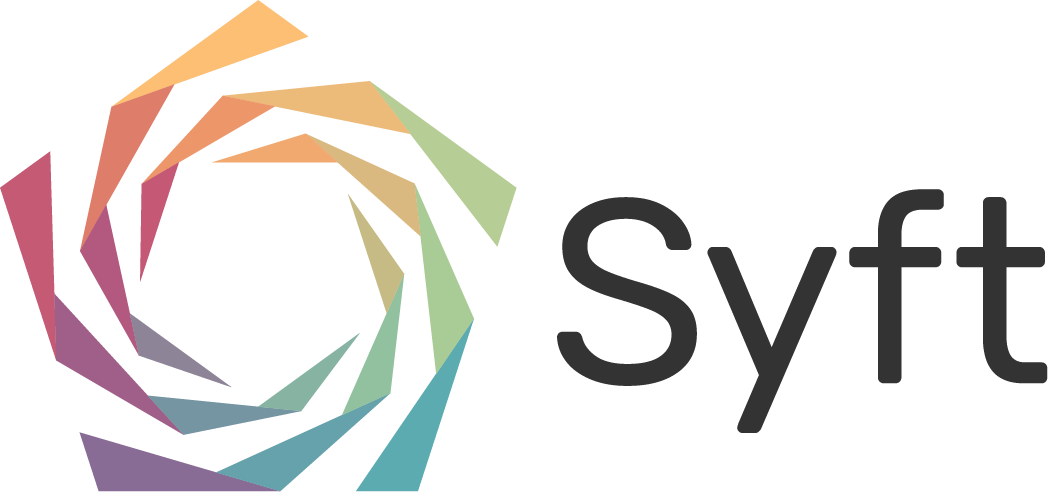

🎤  🎸  ♪♪♪ Starting Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ >             Use at your own risk.
♫♫♫ >
♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... DONE!
♫♫♫ >
♫♫♫ > STEP 1: Send the following code to your Duet Partner!

import syft as sy
duet = sy.duet("d38d6a210cafb403b5f194c3a07933c1")

♫♫♫ > STEP 2: Running the code above will print out a 'Client ID'.
♫♫♫ >         Have your duet partner send it to you and enter it below!

♫♫♫ > Duet Partner's Client ID: df06bc7abf4871837fa6f238e9b6382d
♫♫♫ > Connecting...
♫♫♫ > ...using a running event loop...

♫♫♫ > CONNECTED!



1

♫♫♫ > DUET LIVE STATUS  -  Objects: 0  Requests: 0   Messages: 0                                Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
♫♫♫ > DUET LIVE STATUS  *  Objects: 0  Requests: 0   Messages: 0                                Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
♫♫♫ > DUET LIVE STATUS  -  Objects: 18  Requests: 0   Messages: 12132                                

In [3]:
# Start Duet local instance
duet = sy.launch_duet(loopback=False)
sy.logger.add(sink="./syft_do.log")

## Checkpoint 1 : Now STOP and run the Data Scientist notebook until Checkpoint 1

### Prepare the data

Define data transformations

In [4]:
transforms_input = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(0.1307,0.3081)])

Set training data

In [5]:
train_data = torchvision.datasets.MNIST('./data/',train=True,download=True)

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100.4%

180.4%

Done!


/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Apply data transformations. Inputs and targets should be tensors to send to the duet store.

In [6]:
class PrepareDataset:
    def __init__(self,train_data,transform_input=None, transform_output=None):
        self.train_data = train_data
        self.transform_input = transform_input
        self.transform_output = transform_output
    def __len__(self):
        len(self.train_data)
    def __getitem__(self):
        inputs = []
        targets = []
        for i in range(len(train_data)):
            tinput = train_data[i][0]
            target = torch.as_tensor(train_data[i][1])
            if self.transform_input:
                tinput = self.transform_input(tinput)
            if self.transform_output:
                target = self.transform_output(target)
            inputs.append(tinput)
            targets.append(target)
        return inputs, targets



In [7]:
train_set = PrepareDataset(train_data, transform_input=transforms_input)

Get processed data

In [8]:
inputs, targets = train_set.__getitem__()

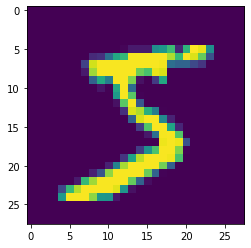

In [9]:
plt.imshow(inputs[0][0,:,:])
plt.show()

In [10]:
targets[0]

tensor(5)

In [11]:
inputs = torch.cat(inputs)
targets = torch.stack(targets)
train_len = torch.as_tensor(len(targets))

### Send data pointers to duet 

Set tags to input and targets

In [12]:
inputs.tag("inputs")
targets.tag("targets")
train_len.tag("train_len")

tensor(60000)

Send data pointers and their size

> Make Training data Referenceable over Duet



In [13]:
inputs.send(duet,searchable=True)
targets.send(duet,searchable=True)
train_len.send(duet,searchable=True)

Check that everything is on grid

In [14]:
duet.store.pandas

ID         Tags Description
0  <UID: 7d2a17d7896c41cd82ff9b1c9414533d>     [inputs]            
1  <UID: 82e1efed1307439a8389034c3cd5764e>    [targets]            
2  <UID: 2446785663974c4bb27ea8187c3b7504>  [train_len]

Approve the requests -  handler with no tags accepts everything. Better handlers coming soon.

In [15]:
duet.requests.add_handler(action="accept")

/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callbac

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    raise error
  File "/usr/lib

Check that requests have been approved

In [15]:
duet.requests.pandas

Empty DataFrame
Columns: []
Index: []

/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", 

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ected Float')>) at /home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py:55>
Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 116, in emit
    self._emit_handle_potential_error(event, args[0] if args else None)
  File "/home/cassie_zaf/Desktop/GRACE_temp/env/lib/python3.8/site-packages/pyee/_base.py", line 86, in _emit_handle_potential_error
    rai

## Checkpoint 2: Well Done